#It takes 5-6 hours to run the entire notebook (You've been warned)

# Install and import required libraries

In [2]:
!pip install alpaca-trade-api
!pip install boto3
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import REST, TimeFrame
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import os
import numpy as np
import plotly.express as px

     |████████████████████████████████| 53 kB 2.4 MB/s 
     |████████████████████████████████| 273 kB 10.7 MB/s 
     |████████████████████████████████| 103 kB 97.7 MB/s 
     |████████████████████████████████| 1.3 MB 50.7 MB/s 
     |████████████████████████████████| 636 kB 58.5 MB/s 
     |████████████████████████████████| 271 kB 69.6 MB/s 
     |████████████████████████████████| 160 kB 61.9 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: msgpack
    Found existing installation: msgpack 1.0.3
    Uninstalling msgpack-1.0.3:
      Successfully uninstalled msgpack-1.0.3
     |████████████████████████████████| 131 kB 5.0 MB/s 
     |████████████████████████████████| 8.4 MB 41.6 MB/s 
     |████████████████████████████████| 79 kB 9.5 MB/s 
     |████████████████████████████████| 138 kB 78.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installatio

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


# Retrieve the Data

In this section we will be importing the data from the Alpaca API, cleaning it up and plotting it with plotly. For right now, we will only be utilizing the stocks closing price but we will be doing some feature engineering a bit later.

In [3]:
# Alpaca API Key ID
key = 'API-KEY'

# Alpaca API Secret Key
secret = 'API-KEY-SECRET'

# The endpoint which we will be connecting to
endpoint = 'https://data.alpaca.markets/v2'

# setting up the connection to the Alpaca API
api = tradeapi.REST(key, secret, endpoint)


In [4]:
# Check out what we have for the data (retrieved hourly data points)
nvda = api.get_bars("NVDA", TimeFrame.Minute, start="2021-11-01", adjustment='raw').df
nvda.head()

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2021-11-01 08:00:00+00:00,258.90,258.90,258.90,258.90,741,25,258.431147
2021-11-01 08:01:00+00:00,257.99,257.99,257.55,257.55,772,42,257.669119
2021-11-01 08:02:00+00:00,257.68,257.68,257.30,257.30,1385,56,257.560072
2021-11-01 08:03:00+00:00,257.20,257.40,257.00,257.40,1333,37,257.276572
2021-11-01 08:04:00+00:00,257.21,257.21,257.21,257.21,346,25,257.399884


In [5]:
# Check what the data types are
nvda.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21730 entries, 2021-11-01 08:00:00+00:00 to 2021-12-09 14:40:00+00:00
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   open         21730 non-null  float64
 1   high         21730 non-null  float64
 2   low          21730 non-null  float64
 3   close        21730 non-null  float64
 4   volume       21730 non-null  int64  
 5   trade_count  21730 non-null  int64  
 6   vwap         21730 non-null  float64
dtypes: float64(5), int64(2)
memory usage: 1.3 MB


In [6]:
# Check how many data points we have
nvda.count()

open           21730
high           21730
low            21730
close          21730
volume         21730
trade_count    21730
vwap           21730
dtype: int64

In [7]:
# Rename closing column to Closing_Price
nvda_prices = pd.DataFrame(nvda['close']).rename(columns={'close': 'Closing_Price'})
print(type(nvda_prices))
nvda_prices.head()

<class 'pandas.core.frame.DataFrame'>


,Closing_Price
timestamp,
2021-11-01 08:00:00+00:00,258.90
2021-11-01 08:01:00+00:00,257.55
2021-11-01 08:02:00+00:00,257.30
2021-11-01 08:03:00+00:00,257.40
2021-11-01 08:04:00+00:00,257.21


In [8]:
# Check out the descriptive statistics
nvda_prices.describe()

,Closing_Price
count,21730.000000
mean,307.318201
std,18.967956
min,252.525000
25%,299.900000
50%,309.180000
75%,320.680000
max,346.070000


In [9]:
# Reformat the timestamp column
nvda_prices.index = nvda_prices.index.strftime('%Y-%m-%d %H:%M:%S')
nvda_prices.head()

,Closing_Price
timestamp,
2021-11-01 08:00:00,258.90
2021-11-01 08:01:00,257.55
2021-11-01 08:02:00,257.30
2021-11-01 08:03:00,257.40
2021-11-01 08:04:00,257.21


In [10]:
# Turn the index into a column which allows for easier plotting with plotly
nvda_prices.reset_index(level=0, inplace=True)
nvda_prices.head()

,timestamp,Closing_Price
0,2021-11-01 08:00:00,258.90
1,2021-11-01 08:01:00,257.55
2,2021-11-01 08:02:00,257.30
3,2021-11-01 08:03:00,257.40
4,2021-11-01 08:04:00,257.21


In [11]:
# Plot the data
df = nvda_prices
fig = px.line(df, x="timestamp", y="Closing_Price", labels={"timestamp": "Date", "Closing_Price": "Closing Price"}, title='Nvdia Closing Prices (Per Minute)')
fig.layout.update(showlegend=True)
fig.show()

# Prepare the data for the LSTM model:
Before we can fit an LSTM model we have to transform the data and create train and test splits

In [12]:
# First we will convert the Nvdia closing prices into a numpy array because we will need it later
closing_prices = nvda_prices["Closing_Price"].to_numpy()

In [13]:
# We are going to use the past 7 data point(s) to predict the next 1 data poin(t)
HORIZON = 1
WINDOW = 7

# Create function to label windowed data
def labeled_window(x, horizon):
  """
  Creates a labeld time series window
  return: The labled window
  """
  return x[:, :-horizon], x[:, -horizon:]


# Visualize what our labeled window will look like
test_window, test_label = labeled_window(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print("Window: {} Label: {}".format(tf.squeeze(test_window).numpy(), tf.squeeze(test_label).numpy()))

Window: [1 2 3 4 5 6 7] Label: 8


In [14]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size, horizon):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = labeled_window(windowed_array, horizon=horizon)

  return windows, labels

# visualize the windows
full_windows, full_labels = make_windows(closing_prices, window_size=WINDOW, horizon=HORIZON)
len(full_windows), len(full_labels)

(21723, 21723)

In [15]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Takes the matching windows and labels and creates training and testing sets from them
  return: Test and Train sets
  """
  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels


train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(17378, 4345, 17378, 4345)

In [16]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.
  return: model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

# Create a Modeling Checkpoint
Now that we have prepared our data for the LSTM model. We are going to create a modeling checkpoint which will allow us to save the best model from each experiment

In [20]:
def modeling_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), verbose=0, save_best_only=True)

# Create a Baseline Model
Now that we have our data prepared for an LSTM model we can create the baseline model

In [18]:
tf.random.set_seed(23)

# Use the past 7 data point(s) to predict the next 1 data point(s)
WINDOW = 7
HORIZON = 1

# Baseline model
inputs = layers.Input(shape=(WINDOW))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(1, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
baseline_model = tf.keras.Model(inputs=inputs, outputs=output, name="baseline_lstm_model")

# Compile model
baseline_model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

baseline_model.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=32,
            validation_data=(test_windows, test_labels),
            callbacks=[modeling_checkpoint(model_name=baseline_model.name)])

INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/baseline_lstm_model/assets


# Evaluate the Model
Now that we have created a baseline LSTM model we can make predictions about what the next data point will be and evaluate the Mean Squarred Error 

In [19]:
# load the best baseline LSTM model
baseline_model = tf.keras.models.load_model("model_experiments/baseline_lstm_model/")
baseline_model.evaluate(test_windows, test_labels)

136/136 [==============================] - 0s 2ms/step - loss: 258.6150


258.614990234375

In [20]:
baseline_model.summary()

Model: "baseline_lstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 lambda (Lambda)             (None, 1, 7)              0         
                                                                 
 lstm (LSTM)                 (None, 1)                 36        
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 38
Trainable params: 38
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Make predictions with our LSTM model
baseline_preds = make_preds(baseline_model, test_windows)
baseline_preds[:7]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([54.081905, 54.081905, 54.081905, 54.081905, 54.081905, 54.081905,
       54.081905], dtype=float32)>

In [22]:
# Now we can evaluate the model by checking the Mean Squared Error
mse = tf.keras.metrics.mean_squared_error(tf.squeeze(test_labels), baseline_preds)

print('MSE: {}'.format(mse.numpy()))

MSE: 66976.96875


# Findings on Baseline LSTM model:
We achieved a MSE value of  66976.96875 for the baseline model.


Now, to optimize the baseline model what we are going to want to do is improve this MSE value the best we can. To start we are going to do the following:

- Test batch sizes of [32, 64, 128] to see if it affects the MSE value
- Create models with hidden units of [32, 64, 128, 256] to see if it affects the MSE value

# Models with hidden units = 1, epochs = 100, and batch sizes [32, 64, 128]

In [23]:
tf.random.set_seed(23)

# Use the past 7 data point(s) to predict the next 1 data point(s)
WINDOW = 7
HORIZON = 1

# batch size = 32
inputs = layers.Input(shape=(WINDOW))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(1, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
optimized_batch_size_model_32 = tf.keras.Model(inputs=inputs, outputs=output, name="batch_size_optimized_lstm_model_32")

# Compile model
optimized_batch_size_model_32.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

optimized_batch_size_model_32.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=32,
            validation_data=(test_windows, test_labels),
            callbacks=[modeling_checkpoint(model_name=optimized_batch_size_model_32.name)])

INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_32/assets


In [24]:
# load the best model
batch_size_32_optimization_model = tf.keras.models.load_model("model_experiments/batch_size_optimized_lstm_model_32/")
batch_size_32_optimization_model.evaluate(test_windows, test_labels)

136/136 [==============================] - 0s 2ms/step - loss: 258.6150


258.614990234375

In [25]:
# Make predictions with our LSTM model
batch_size_optimization_preds_32 = make_preds(batch_size_32_optimization_model, test_windows)
batch_size_optimization_preds_32[:7]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([54.081905, 54.081905, 54.081905, 54.081905, 54.081905, 54.081905,
       54.081905], dtype=float32)>

In [26]:
# Now we can evaluate the model by checking the Mean Squared Error
optimized_batch_size_32_mse = tf.keras.metrics.mean_squared_error(tf.squeeze(test_labels), batch_size_optimization_preds_32)

print('Optimized Batch Size 32 MSE: {}'.format(optimized_batch_size_32_mse.numpy()))

Optimized Batch Size 32 MSE: 66976.96875


In [27]:
tf.random.set_seed(23)

# Use the past 7 data point(s) to predict the next 1 data point(s)
WINDOW = 7
HORIZON = 1

# batch size = 64
inputs = layers.Input(shape=(WINDOW))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(1, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
optimized_batch_size_model_64 = tf.keras.Model(inputs=inputs, outputs=output, name="batch_size_optimized_lstm_model_64")

# Compile model
optimized_batch_size_model_64.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

optimized_batch_size_model_64.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=64,
            validation_data=(test_windows, test_labels),
            callbacks=[modeling_checkpoint(model_name=optimized_batch_size_model_64.name)])

INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_64/assets


In [28]:
# load the best model
batch_size_64_optimization_model = tf.keras.models.load_model("model_experiments/batch_size_optimized_lstm_model_64/")
batch_size_64_optimization_model.evaluate(test_windows, test_labels)

136/136 [==============================] - 0s 1ms/step - loss: 285.6000


285.5999755859375

In [29]:
# Make predictions with our LSTM model
batch_size_optimization_preds_64 = make_preds(batch_size_64_optimization_model, test_windows)
batch_size_optimization_preds_64[:7]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([27.096737, 27.096737, 27.096737, 27.096737, 27.096737, 27.096737,
       27.096737], dtype=float32)>

In [30]:
# Now we can evaluate the model by checking the Mean Squared Error
optimized_batch_size_64_mse = tf.keras.metrics.mean_squared_error(tf.squeeze(test_labels), batch_size_optimization_preds_64)

print('Optimized Batch Size 64 MSE: {}'.format(optimized_batch_size_64_mse.numpy()))

Optimized Batch Size 64 MSE: 81662.6953125


In [31]:
tf.random.set_seed(23)

# Use the past 7 data point(s) to predict the next 1 data point(s)
WINDOW = 7
HORIZON = 1

# batch size = 128
inputs = layers.Input(shape=(WINDOW))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(1, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
optimized_batch_size_model_128 = tf.keras.Model(inputs=inputs, outputs=output, name="batch_size_optimized_lstm_model_128")

# Compile model
optimized_batch_size_model_128.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

optimized_batch_size_model_128.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[modeling_checkpoint(model_name=optimized_batch_size_model_128.name)])

INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/batch_size_optimized_lstm_model_128/assets


In [32]:
# load the best model
batch_size_128_optimization_model = tf.keras.models.load_model("model_experiments/batch_size_optimized_lstm_model_128/")
batch_size_128_optimization_model.evaluate(test_windows, test_labels)

136/136 [==============================] - 0s 1ms/step - loss: 299.0950


299.09503173828125

In [33]:
# Make predictions with our LSTM model
batch_size_optimization_preds_128 = make_preds(batch_size_128_optimization_model, test_windows)
batch_size_optimization_preds_128[:7]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([13.601867, 13.601867, 13.601867, 13.601867, 13.601867, 13.601867,
       13.601867], dtype=float32)>

In [34]:
# Now we can evaluate the model by checking the Mean Squared Error
optimized_batch_size_128_mse = tf.keras.metrics.mean_squared_error(tf.squeeze(test_labels), batch_size_optimization_preds_128)

print('Optimized Batch Size MSE: {}'.format(optimized_batch_size_128_mse.numpy()))

Optimized Batch Size MSE: 89553.1015625


In [35]:
print(
    'The MSE scores were: \n {} for a batch size of 32 \n {} for a batch size of 64 \n {} for a batch size of 128'.format(optimized_batch_size_32_mse.numpy(), optimized_batch_size_64_mse.numpy(), optimized_batch_size_128_mse.numpy())
)

The MSE scores were: 
 66976.96875 for a batch size of 32 
 81662.6953125 for a batch size of 64 
 89553.1015625 for a batch size of 128


#Results

In [36]:
# Plot the data
Batch_size = [32, 64, 128]
MSE_Scores = [optimized_batch_size_32_mse.numpy(), optimized_batch_size_64_mse.numpy(), optimized_batch_size_128_mse.numpy()]


df = pd.DataFrame({'Batch_Size':Batch_size, 'MSE':MSE_Scores})
df.head()


fig = px.line(df, x="Batch_Size", y="MSE", title='MSE Scores vs. Batch Size')
fig.layout.update(showlegend=True)
fig.show()

##The batch size which gave us the best MSE value was **32** and we will be using it for the rest of our experiments

# Models with hidden units = [32, 64, 128, 256], epochs = 100, batch size = 32

In [37]:
tf.random.set_seed(23)

# Use the past 7 data point(s) to predict the next 1 data point(s)
WINDOW = 7
HORIZON = 1

# hidden units = 32
inputs = layers.Input(shape=(WINDOW))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
optimized_hidden_units_model_32 = tf.keras.Model(inputs=inputs, outputs=output, name="optimized_hidden_units_model_32")

# Compile model
optimized_hidden_units_model_32.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

optimized_hidden_units_model_32.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=32,
            validation_data=(test_windows, test_labels),
            callbacks=[modeling_checkpoint(model_name=optimized_hidden_units_model_32.name)])

INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_32/assets


In [38]:
# load the best model
hidden_units_32_optimization_model = tf.keras.models.load_model("model_experiments/optimized_hidden_units_model_32/")
hidden_units_32_optimization_model.evaluate(test_windows, test_labels)

136/136 [==============================] - 0s 2ms/step - loss: 0.4760


0.47595834732055664

In [39]:
# Make predictions with our LSTM model
hidden_units_optimization_preds_32 = make_preds(hidden_units_32_optimization_model, test_windows)
hidden_units_optimization_preds_32[:7]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([323.27954, 323.0498 , 322.91226, 322.702  , 322.47256, 322.2578 ,
       322.05032], dtype=float32)>

In [40]:
# Now we can evaluate the model by checking the Mean Squared Error
optimized_hidden_units_32_mse = tf.keras.metrics.mean_squared_error(tf.squeeze(test_labels), hidden_units_optimization_preds_32)

print('Optimized hidden units 32 MSE: {}'.format(optimized_hidden_units_32_mse.numpy()))

Optimized hidden units 32 MSE: 0.6015300750732422


In [41]:
tf.random.set_seed(23)

# Use the past 7 data point(s) to predict the next 1 data point(s)
WINDOW = 7
HORIZON = 1

# hidden units = 64
inputs = layers.Input(shape=(WINDOW))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(64, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
optimized_hidden_units_model_64 = tf.keras.Model(inputs=inputs, outputs=output, name="optimized_hidden_units_model_64")

# Compile model
optimized_hidden_units_model_64.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

optimized_hidden_units_model_64.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=32,
            validation_data=(test_windows, test_labels),
            callbacks=[modeling_checkpoint(model_name=optimized_hidden_units_model_64.name)])

INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_64/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_64/assets


In [42]:
# load the best model
hidden_units_64_optimization_model = tf.keras.models.load_model("model_experiments/optimized_hidden_units_model_64/")
hidden_units_64_optimization_model.evaluate(test_windows, test_labels)

136/136 [==============================] - 0s 2ms/step - loss: 0.4717


0.4717291593551636

In [43]:
# Make predictions with our LSTM model
hidden_units_optimization_preds_64 = make_preds(hidden_units_64_optimization_model, test_windows)
hidden_units_optimization_preds_64[:7]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([323.27393, 323.07547, 322.99783, 322.7837 , 322.56686, 322.34528,
       322.07767], dtype=float32)>

In [44]:
# Now we can evaluate the model by checking the Mean Squared Error
optimized_hidden_units_64_mse = tf.keras.metrics.mean_squared_error(tf.squeeze(test_labels), hidden_units_optimization_preds_64)

print('Optimized hidden units 64 MSE: {}'.format(optimized_hidden_units_64_mse.numpy()))

Optimized hidden units 64 MSE: 0.5939862728118896


In [42]:
tf.random.set_seed(23)

# Use the past 7 data point(s) to predict the next 1 data point(s)
WINDOW = 7
HORIZON = 1

# hidden units = 128
inputs = layers.Input(shape=(WINDOW))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
optimized_hidden_units_model_128 = tf.keras.Model(inputs=inputs, outputs=output, name="optimized_hidden_units_model_128")

# Compile model
optimized_hidden_units_model_128.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

optimized_hidden_units_model_128.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=32,
            validation_data=(test_windows, test_labels),
            callbacks=[modeling_checkpoint(model_name=optimized_hidden_units_model_128.name)])

INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_128/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_128/assets


In [43]:
# load the best model
hidden_units_128_optimization_model = tf.keras.models.load_model("model_experiments/optimized_hidden_units_model_128/")
hidden_units_128_optimization_model.evaluate(test_windows, test_labels)

136/136 [==============================] - 0s 2ms/step - loss: 0.4747


0.4747040569782257

In [44]:
# Make predictions with our LSTM model
hidden_units_optimization_preds_128 = make_preds(hidden_units_128_optimization_model, test_windows)
hidden_units_optimization_preds_128[:7]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([314.45114, 314.43292, 314.44543, 314.58865, 314.7183 , 314.71692,
       314.7372 ], dtype=float32)>

In [45]:
# Now we can evaluate the model by checking the Mean Squared Error
optimized_hidden_units_128_mse = tf.keras.metrics.mean_squared_error(tf.squeeze(test_labels), hidden_units_optimization_preds_128)

print('Optimized hidden units 128 MSE: {}'.format(optimized_hidden_units_128_mse.numpy()))

Optimized hidden units 128 MSE: 0.6040881276130676


In [49]:
tf.random.set_seed(23)

# Use the past 7 data point(s) to predict the next 1 data point(s)
WINDOW = 7
HORIZON = 1

# hidden units = 256
inputs = layers.Input(shape=(WINDOW))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(256, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
optimized_hidden_units_model_256 = tf.keras.Model(inputs=inputs, outputs=output, name="optimized_hidden_units_model_256")

# Compile model
optimized_hidden_units_model_256.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

optimized_hidden_units_model_256.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=32,
            validation_data=(test_windows, test_labels),
            callbacks=[modeling_checkpoint(model_name=optimized_hidden_units_model_256.name)])

INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_256/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_256/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_256/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_256/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_256/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_256/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_256/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_256/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_256/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_256/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_256/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_256/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_256/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_256/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_256/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_256/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_256/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_256/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_256/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_256/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_256/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_256/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_256/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_256/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_256/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_256/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_256/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_256/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_256/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_hidden_units_model_256/assets


In [50]:
# load the best model
hidden_units_256_optimization_model = tf.keras.models.load_model("model_experiments/optimized_hidden_units_model_256/")
hidden_units_256_optimization_model.evaluate(test_windows, test_labels)

136/136 [==============================] - 1s 2ms/step - loss: 0.4457


0.44567322731018066

In [51]:
# Make predictions with our LSTM model
hidden_units_optimization_preds_256 = make_preds(hidden_units_256_optimization_model, test_windows)
hidden_units_optimization_preds_256[:7]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([323.2559 , 323.05493, 323.0102 , 322.76532, 322.47565, 322.3212 ,
       322.1061 ], dtype=float32)>

In [52]:
# Now we can evaluate the model by checking the Mean Squared Error
optimized_hidden_units_256_mse = tf.keras.metrics.mean_squared_error(tf.squeeze(test_labels), hidden_units_optimization_preds_256)

print('Optimized hidden units 256 MSE: {}'.format(optimized_hidden_units_256_mse.numpy()))

Optimized hidden units 256 MSE: 0.529349148273468


In [53]:
print(
    'The MSE scores were: \n {} for 32 hidden units \n {} for 64 hidden units \n {} for 128 hidden units \n {} for 256 hidden units'.format(optimized_hidden_units_32_mse.numpy(), optimized_hidden_units_64_mse.numpy(), optimized_hidden_units_128_mse.numpy(), optimized_hidden_units_256_mse.numpy())
)

The MSE scores were: 
 0.6015300750732422 for 32 hidden units 
 0.5939862728118896 for 64 hidden units 
 0.4930362403392792 for 128 hidden units 
 0.529349148273468 for 256 hidden units


#Results

In [54]:
# Plot the data
Hidden_units = [32, 64, 128, 256]
MSE_Scores = [optimized_hidden_units_32_mse.numpy(), optimized_hidden_units_64_mse.numpy(), optimized_hidden_units_128_mse.numpy(), optimized_hidden_units_256_mse.numpy()]


df = pd.DataFrame({'Hidden_Units':Hidden_units, 'MSE':MSE_Scores})
df.head()


fig = px.line(df, x="Hidden_Units", y="MSE", title='MSE Scores vs. Hidden Units')
fig.layout.update(showlegend=True)
fig.show()

128 hidden units gave us the best result for the MSE value. So from now on we will be using **128 hidden units** and a batch size of **32** for our models

# Now lets add a drop out layer
Drop out layers help prevent overtraining/overfitting so it will be a good idea to have it in our models

We will be using the following dropout rates [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [55]:
tf.random.set_seed(23)

# Use the past 7 data point(s) to predict the next 1 data point(s)
WINDOW = 7
HORIZON = 1

# dropout 0.1
inputs = layers.Input(shape=(WINDOW))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation="relu")(x)
x = layers.Dropout(0.1)(x)
output = layers.Dense(HORIZON)(x)
optimized_dropout_01 = tf.keras.Model(inputs=inputs, outputs=output, name="optimized_dropout_01")

# Compile model
optimized_dropout_01.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

optimized_dropout_01.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=32,
            validation_data=(test_windows, test_labels),
            callbacks=[modeling_checkpoint(model_name=optimized_dropout_01.name)])

INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_01/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_01/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_01/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_01/assets


In [56]:
# load the best model
optimized_dropout_model_01 = tf.keras.models.load_model("model_experiments/optimized_dropout_01/")
optimized_dropout_model_01.evaluate(test_windows, test_labels)

136/136 [==============================] - 0s 2ms/step - loss: 2.4179


2.417879581451416

In [57]:
# Make predictions with our LSTM model
optimized_dropout_preds_01 = make_preds(optimized_dropout_model_01, test_windows)
optimized_dropout_preds_01[:7]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([320.5961 , 320.43884, 320.35773, 320.13458, 319.86942, 319.67377,
       319.47723], dtype=float32)>

In [58]:
# Now we can evaluate the model by checking the Mean Squared Error
optimized_dropout_mse_01 = tf.keras.metrics.mean_squared_error(tf.squeeze(test_labels), optimized_dropout_preds_01)

print('Optimized dropout 0.1 MSE: {}'.format(optimized_dropout_mse_01.numpy()))

Optimized dropout 0.1 MSE: 6.406930923461914


In [50]:
tf.random.set_seed(23)

# Use the past 7 data point(s) to predict the next 1 data point(s)
WINDOW = 7
HORIZON = 1

# dropout 0.2
inputs = layers.Input(shape=(WINDOW))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation="relu")(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(HORIZON)(x)
optimized_dropout_02 = tf.keras.Model(inputs=inputs, outputs=output, name="optimized_dropout_02")

# Compile model
optimized_dropout_02.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

optimized_dropout_02.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=32,
            validation_data=(test_windows, test_labels),
            callbacks=[modeling_checkpoint(model_name=optimized_dropout_02.name)])

INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_02/assets


In [51]:
# load the best model
optimized_dropout_model_02 = tf.keras.models.load_model("model_experiments/optimized_dropout_02/")
optimized_dropout_model_02.evaluate(test_windows, test_labels)

136/136 [==============================] - 0s 2ms/step - loss: 7.3372


7.337184906005859

In [52]:
# Make predictions with our LSTM model
optimized_dropout_preds_02 = make_preds(optimized_dropout_model_02, test_windows)
optimized_dropout_preds_02[:7]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([307.06125, 307.04947, 307.08612, 307.17642, 307.23953, 307.26123,
       307.30457], dtype=float32)>

In [53]:
# Now we can evaluate the model by checking the Mean Squared Error
optimized_dropout_mse_02 = tf.keras.metrics.mean_squared_error(tf.squeeze(test_labels), optimized_dropout_preds_02)

print('Optimized dropout 0.2 MSE: {}'.format(optimized_dropout_mse_02.numpy()))

Optimized dropout 0.2 MSE: 54.904266357421875


In [63]:
tf.random.set_seed(23)

# Use the past 7 data point(s) to predict the next 1 data point(s)
WINDOW = 7
HORIZON = 1

# dropout 0.3
inputs = layers.Input(shape=(WINDOW))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(HORIZON)(x)
optimized_dropout_03 = tf.keras.Model(inputs=inputs, outputs=output, name="optimized_dropout_03")

# Compile model
optimized_dropout_03.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

optimized_dropout_03.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=32,
            validation_data=(test_windows, test_labels),
            callbacks=[modeling_checkpoint(model_name=optimized_dropout_03.name)])

INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_03/assets


In [64]:
# load the best model
optimized_dropout_model_03 = tf.keras.models.load_model("model_experiments/optimized_dropout_03/")
optimized_dropout_model_03.evaluate(test_windows, test_labels)

136/136 [==============================] - 0s 2ms/step - loss: 4.5796


4.579585552215576

In [65]:
# Make predictions with our LSTM model
optimized_dropout_preds_03 = make_preds(optimized_dropout_model_03, test_windows)
optimized_dropout_preds_03[:7]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([317.97836, 317.8441 , 317.7675 , 317.55554, 317.301  , 317.10568,
       316.91467], dtype=float32)>

In [66]:
# Now we can evaluate the model by checking the Mean Squared Error
optimized_dropout_mse_03 = tf.keras.metrics.mean_squared_error(tf.squeeze(test_labels), optimized_dropout_preds_03)

print('Optimized dropout 0.3 MSE: {}'.format(optimized_dropout_mse_03.numpy()))

Optimized dropout 0.3 MSE: 21.968669891357422


In [67]:
tf.random.set_seed(23)

# Use the past 7 data point(s) to predict the next 1 data point(s)
WINDOW = 7
HORIZON = 1

# dropout 0.4
inputs = layers.Input(shape=(WINDOW))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation="relu")(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(HORIZON)(x)
optimized_dropout_04 = tf.keras.Model(inputs=inputs, outputs=output, name="optimized_dropout_04")

# Compile model
optimized_dropout_04.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

optimized_dropout_04.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=32,
            validation_data=(test_windows, test_labels),
            callbacks=[modeling_checkpoint(model_name=optimized_dropout_04.name)])

INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_04/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_04/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_04/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_04/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_04/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_04/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_04/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_04/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_04/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_04/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_04/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_04/assets


In [68]:
# load the best model
optimized_dropout_model_04 = tf.keras.models.load_model("model_experiments/optimized_dropout_04/")
optimized_dropout_model_04.evaluate(test_windows, test_labels)

136/136 [==============================] - 0s 2ms/step - loss: 0.7886


0.7886359691619873

In [69]:
# Make predictions with our LSTM model
optimized_dropout_preds_04 = make_preds(optimized_dropout_model_04, test_windows)
optimized_dropout_preds_04[:7]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([322.67563, 322.55084, 322.47443, 322.2663 , 322.0122 , 321.81244,
       321.62186], dtype=float32)>

In [70]:
# Now we can evaluate the model by checking the Mean Squared Error
optimized_dropout_mse_04 = tf.keras.metrics.mean_squared_error(tf.squeeze(test_labels), optimized_dropout_preds_04)

print('Optimized dropout 0.4 MSE: {}'.format(optimized_dropout_mse_04.numpy()))

Optimized dropout 0.4 MSE: 1.2378419637680054


In [71]:
tf.random.set_seed(23)

# Use the past 7 data point(s) to predict the next 1 data point(s)
WINDOW = 7
HORIZON = 1

# dropout 0.5
inputs = layers.Input(shape=(WINDOW))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(HORIZON)(x)
optimized_dropout_05 = tf.keras.Model(inputs=inputs, outputs=output, name="optimized_dropout_05")

# Compile model
optimized_dropout_05.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

optimized_dropout_05.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=32,
            validation_data=(test_windows, test_labels),
            callbacks=[modeling_checkpoint(model_name=optimized_dropout_05.name)])

INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_05/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_05/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_05/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_05/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_05/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_05/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_05/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_05/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_05/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_05/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_05/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_05/assets


In [72]:
# load the best model
optimized_dropout_model_05 = tf.keras.models.load_model("model_experiments/optimized_dropout_05/")
optimized_dropout_model_05.evaluate(test_windows, test_labels)

136/136 [==============================] - 0s 2ms/step - loss: 3.7852


3.7851524353027344

In [73]:
# Make predictions with our LSTM model
optimized_dropout_preds_05 = make_preds(optimized_dropout_model_05, test_windows)
optimized_dropout_preds_05[:7]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([318.89035, 318.75867, 318.6767 , 318.47443, 318.21417, 318.01953,
       317.8158 ], dtype=float32)>

In [74]:
# Now we can evaluate the model by checking the Mean Squared Error
optimized_dropout_mse_05 = tf.keras.metrics.mean_squared_error(tf.squeeze(test_labels), optimized_dropout_preds_05)

print('Optimized dropout 0.5 MSE: {}'.format(optimized_dropout_mse_05.numpy()))

Optimized dropout 0.5 MSE: 15.186596870422363


In [75]:
tf.random.set_seed(23)

# Use the past 7 data point(s) to predict the next 1 data point(s)
WINDOW = 7
HORIZON = 1

# dropout 0.6
inputs = layers.Input(shape=(WINDOW))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation="relu")(x)
x = layers.Dropout(0.6)(x)
output = layers.Dense(HORIZON)(x)
optimized_dropout_06 = tf.keras.Model(inputs=inputs, outputs=output, name="optimized_dropout_06")

# Compile model
optimized_dropout_06.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

optimized_dropout_06.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=32,
            validation_data=(test_windows, test_labels),
            callbacks=[modeling_checkpoint(model_name=optimized_dropout_06.name)])

INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_06/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_06/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_06/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_06/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_06/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_06/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_06/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_06/assets


In [76]:
# load the best model
optimized_dropout_model_06 = tf.keras.models.load_model("model_experiments/optimized_dropout_06/")
optimized_dropout_model_06.evaluate(test_windows, test_labels)

136/136 [==============================] - 0s 2ms/step - loss: 3.5269


3.5269064903259277

In [77]:
# Make predictions with our LSTM model
optimized_dropout_preds_06 = make_preds(optimized_dropout_model_06, test_windows)
optimized_dropout_preds_06[:7]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([318.7905 , 318.6705 , 318.5964 , 318.39233, 318.1428 , 317.94714,
       317.7608 ], dtype=float32)>

In [78]:
# Now we can evaluate the model by checking the Mean Squared Error
optimized_dropout_mse_06 = tf.keras.metrics.mean_squared_error(tf.squeeze(test_labels), optimized_dropout_preds_06)

print('Optimized dropout 0.6 MSE: {}'.format(optimized_dropout_mse_06.numpy()))

Optimized dropout 0.6 MSE: 13.74324893951416


In [79]:
tf.random.set_seed(23)

# Use the past 7 data point(s) to predict the next 1 data point(s)
WINDOW = 7
HORIZON = 1

# dropout 0.7
inputs = layers.Input(shape=(WINDOW))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation="relu")(x)
x = layers.Dropout(0.7)(x)
output = layers.Dense(HORIZON)(x)
optimized_dropout_07 = tf.keras.Model(inputs=inputs, outputs=output, name="optimized_dropout_07")

# Compile model
optimized_dropout_07.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

optimized_dropout_07.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=32,
            validation_data=(test_windows, test_labels),
            callbacks=[modeling_checkpoint(model_name=optimized_dropout_07.name)])

INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_07/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_07/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_07/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_07/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_07/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_07/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_07/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_07/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_07/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_07/assets


In [80]:
# load the best model
optimized_dropout_model_07 = tf.keras.models.load_model("model_experiments/optimized_dropout_07/")
optimized_dropout_model_07.evaluate(test_windows, test_labels)

136/136 [==============================] - 0s 2ms/step - loss: 16.2781


16.278093338012695

In [81]:
# Make predictions with our LSTM model
optimized_dropout_preds_07 = make_preds(optimized_dropout_model_07, test_windows)
optimized_dropout_preds_07[:7]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([305.3425 , 305.23123, 305.16013, 304.9776 , 304.7443 , 304.56638,
       304.38263], dtype=float32)>

In [82]:
# Now we can evaluate the model by checking the Mean Squared Error
optimized_dropout_mse_07 = tf.keras.metrics.mean_squared_error(tf.squeeze(test_labels), optimized_dropout_preds_07)

print('Optimized dropout 0.7 MSE: {}'.format(optimized_dropout_mse_07.numpy()))

Optimized dropout 0.7 MSE: 268.0052490234375


In [83]:
tf.random.set_seed(23)

# Use the past 7 data point(s) to predict the next 1 data point(s)
WINDOW = 7
HORIZON = 1

# dropout 0.8
inputs = layers.Input(shape=(WINDOW))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation="relu")(x)
x = layers.Dropout(0.8)(x)
output = layers.Dense(HORIZON)(x)
optimized_dropout_08 = tf.keras.Model(inputs=inputs, outputs=output, name="optimized_dropout_08")

# Compile model
optimized_dropout_08.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

optimized_dropout_08.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=32,
            validation_data=(test_windows, test_labels),
            callbacks=[modeling_checkpoint(model_name=optimized_dropout_08.name)])

INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_08/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_08/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_08/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_08/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_08/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_08/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_08/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_08/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_08/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_08/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_08/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_08/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_08/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_08/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_08/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_08/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_08/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_08/assets


In [84]:
# load the best model
optimized_dropout_model_08 = tf.keras.models.load_model("model_experiments/optimized_dropout_08/")
optimized_dropout_model_08.evaluate(test_windows, test_labels)

136/136 [==============================] - 0s 2ms/step - loss: 37.6072


37.607208251953125

In [85]:
# Make predictions with our LSTM model
optimized_dropout_preds_08 = make_preds(optimized_dropout_model_08, test_windows)
optimized_dropout_preds_08[:7]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([282.99918, 282.89676, 282.8413 , 282.68277, 282.47128, 282.3158 ,
       282.1524 ], dtype=float32)>

In [86]:
# Now we can evaluate the model by checking the Mean Squared Error
optimized_dropout_mse_08 = tf.keras.metrics.mean_squared_error(tf.squeeze(test_labels), optimized_dropout_preds_08)

print('Optimized dropout 0.8 MSE: {}'.format(optimized_dropout_mse_08.numpy()))

Optimized dropout 0.8 MSE: 1420.9814453125


In [87]:
tf.random.set_seed(23)

# Use the past 7 data point(s) to predict the next 1 data point(s)
WINDOW = 7
HORIZON = 1

# dropout 0.9
inputs = layers.Input(shape=(WINDOW))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation="relu")(x)
x = layers.Dropout(0.9)(x)
output = layers.Dense(HORIZON)(x)
optimized_dropout_09 = tf.keras.Model(inputs=inputs, outputs=output, name="optimized_dropout_09")

# Compile model
optimized_dropout_09.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

optimized_dropout_09.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=32,
            validation_data=(test_windows, test_labels),
            callbacks=[modeling_checkpoint(model_name=optimized_dropout_09.name)])

INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_09/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_09/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_09/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_09/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_09/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_09/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_09/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_09/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_09/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_09/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_09/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_09/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_09/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_09/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_09/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_09/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_09/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_09/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_09/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_09/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_09/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_09/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_09/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_09/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_09/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_09/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_09/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dropout_09/assets


In [88]:
# load the best model
optimized_dropout_model_09 = tf.keras.models.load_model("model_experiments/optimized_dropout_09/")
optimized_dropout_model_09.evaluate(test_windows, test_labels)

136/136 [==============================] - 0s 2ms/step - loss: 68.0040


68.00395965576172

In [89]:
# Make predictions with our LSTM model
optimized_dropout_preds_09 = make_preds(optimized_dropout_model_09, test_windows)
optimized_dropout_preds_09[:7]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([251.26485, 251.17517, 251.12428, 250.99199, 250.82648, 250.69614,
       250.55695], dtype=float32)>

In [90]:
# Now we can evaluate the model by checking the Mean Squared Error
optimized_dropout_mse_09 = tf.keras.metrics.mean_squared_error(tf.squeeze(test_labels), optimized_dropout_preds_09)

print('Optimized dropout 0.9 MSE: {}'.format(optimized_dropout_mse_09.numpy()))

Optimized dropout 0.9 MSE: 4638.81103515625


In [91]:
print(
    'The MSE values from the dropout experiments are as follows:\n{} for a dropout of 0.1\n{} for a dropout of 0.2\n{} for a dropout of 0.3\n{} for a dropout of 0.4\n{} for a dropout of 0.5\n{} for a dropout of 0.6\n{} for a dropout of 0.7\n{} for a dropout of 0.8\n{} for a droupout of 0.9'.format(optimized_dropout_mse_01.numpy(), optimized_dropout_mse_02.numpy(), optimized_dropout_mse_03.numpy(),
                                    optimized_dropout_mse_04.numpy(), optimized_dropout_mse_05.numpy(), optimized_dropout_mse_06.numpy(),
                                    optimized_dropout_mse_07.numpy(), optimized_dropout_mse_08.numpy(), optimized_dropout_mse_09.numpy(),
                                    )
)

The MSE values from the dropout experiments are as follows:
6.406930923461914 for a dropout of 0.1
0.6371151208877563 for a dropout of 0.2
21.968669891357422 for a dropout of 0.3
1.2378419637680054 for a dropout of 0.4
15.186596870422363 for a dropout of 0.5
13.74324893951416 for a dropout of 0.6
268.0052490234375 for a dropout of 0.7
1420.9814453125 for a dropout of 0.8
4638.81103515625 for a droupout of 0.9


#Results

In [92]:
# Plot the data
droupout_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
MSE_Scores = [optimized_dropout_mse_01.numpy(), optimized_dropout_mse_02.numpy(),
              optimized_dropout_mse_03.numpy(), optimized_dropout_mse_04.numpy(),
              optimized_dropout_mse_05.numpy(), optimized_dropout_mse_06.numpy(),
              optimized_dropout_mse_07.numpy(), optimized_dropout_mse_08.numpy(),
              optimized_dropout_mse_09.numpy()]


df = pd.DataFrame({'Dropout_Rates':droupout_rates, 'MSE':MSE_Scores})
df.head()


fig = px.line(df, x="Dropout_Rates", y="MSE", title='MSE Scores vs. Dropout Rates')
fig.layout.update(showlegend=True)
fig.show()

### Adding a dropout layer may not add much value but we will keep these values in mind and add them in later once we have a larger LSTM model. It may help a larger model better than our small model.

# Add more Dense layers
In this section we will be adding more layers to see if it has an affect on the MSE value. We will be testing models with hidden layers from 1 - 5. Actually we really shouldn't even need more than 3. But, we will test 5 just for fun.

In [46]:
tf.random.set_seed(23)

# Use the past 7 data point(s) to predict the next 1 data point(s)
WINDOW = 7
HORIZON = 1

# Add 1 more Dense layer
inputs = layers.Input(shape=(WINDOW))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation="relu")(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(HORIZON)(x)
optimized_dense_layer_01 = tf.keras.Model(inputs=inputs, outputs=output, name="optimized_dense_layer_01")

# Compile model
optimized_dense_layer_01.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

optimized_dense_layer_01.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=32,
            validation_data=(test_windows, test_labels),
            callbacks=[modeling_checkpoint(model_name=optimized_dense_layer_01.name)])

INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_01/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_01/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_01/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_01/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_01/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_01/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_01/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_01/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_01/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_01/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_01/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_01/assets


In [47]:
# load the best model
optimized_dense_layer_model_01 = tf.keras.models.load_model("model_experiments/optimized_dense_layer_01/")
optimized_dense_layer_model_01.evaluate(test_windows, test_labels)

136/136 [==============================] - 0s 2ms/step - loss: 0.4465


0.4465450048446655

In [48]:
# Make predictions with our LSTM model
optimized_dense_layer_preds_01 = make_preds(optimized_dense_layer_model_01, test_windows)
optimized_dense_layer_preds_01[:7]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([314.61493, 314.5731 , 314.61194, 314.76535, 314.92245, 314.95276,
       314.9445 ], dtype=float32)>

In [49]:
# Now we can evaluate the model by checking the Mean Squared Error
optimized_dense_layer_mse_01 = tf.keras.metrics.mean_squared_error(tf.squeeze(test_labels), optimized_dense_layer_preds_01)

print('Optimized dense layer 01 MSE: {}'.format(optimized_dense_layer_mse_01.numpy()))

Optimized dense layer 01 MSE: 0.5297045111656189


In [97]:
tf.random.set_seed(23)

# Use the past 7 data point(s) to predict the next 1 data point(s)
WINDOW = 7
HORIZON = 1

# Add 2 more Dense layers
inputs = layers.Input(shape=(WINDOW))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation="relu")(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
output = layers.Dense(HORIZON)(x)
optimized_dense_layer_02 = tf.keras.Model(inputs=inputs, outputs=output, name="optimized_dense_layer_02")

# Compile model
optimized_dense_layer_02.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

optimized_dense_layer_02.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=32,
            validation_data=(test_windows, test_labels),
            callbacks=[modeling_checkpoint(model_name=optimized_dense_layer_02.name)])

INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_02/assets


In [98]:
# load the best model
optimized_dense_layer_model_02 = tf.keras.models.load_model("model_experiments/optimized_dense_layer_02/")
optimized_dense_layer_model_02.evaluate(test_windows, test_labels)

136/136 [==============================] - 0s 2ms/step - loss: 0.4621


0.4620596766471863

In [99]:
# Make predictions with our LSTM model
optimized_dense_layer_preds_02 = make_preds(optimized_dense_layer_model_02, test_windows)
optimized_dense_layer_preds_02[:7]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([323.30484, 323.09964, 323.0167 , 322.76373, 322.53476, 322.3338 ,
       322.095  ], dtype=float32)>

In [100]:
# Now we can evaluate the model by checking the Mean Squared Error
optimized_dense_layer_mse_02 = tf.keras.metrics.mean_squared_error(tf.squeeze(test_labels), optimized_dense_layer_preds_02)

print('Optimized dense layer 02 MSE: {}'.format(optimized_dense_layer_mse_02.numpy()))

Optimized dense layer 02 MSE: 0.5691251158714294


In [101]:
tf.random.set_seed(23)

# Use the past 7 data point(s) to predict the next 1 data point(s)
WINDOW = 7
HORIZON = 1

# Add 3 more Dense layers
inputs = layers.Input(shape=(WINDOW))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation="relu")(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(16, activation='relu')(x)
output = layers.Dense(HORIZON)(x)
optimized_dense_layer_03 = tf.keras.Model(inputs=inputs, outputs=output, name="optimized_dense_layer_03")

# Compile model
optimized_dense_layer_03.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

optimized_dense_layer_03.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=32,
            validation_data=(test_windows, test_labels),
            callbacks=[modeling_checkpoint(model_name=optimized_dense_layer_03.name)])

INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_03/assets


In [102]:
# load the best model
optimized_dense_layer_model_03 = tf.keras.models.load_model("model_experiments/optimized_dense_layer_03/")
optimized_dense_layer_model_03.evaluate(test_windows, test_labels)

136/136 [==============================] - 0s 2ms/step - loss: 0.4761


0.47614070773124695

In [103]:
# Make predictions with our LSTM model
optimized_dense_layer_preds_03 = make_preds(optimized_dense_layer_model_03, test_windows)
optimized_dense_layer_preds_03[:7]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([323.22327, 323.0436 , 322.98578, 322.74545, 322.5164 , 322.26797,
       322.06223], dtype=float32)>

In [104]:
# Now we can evaluate the model by checking the Mean Squared Error
optimized_dense_layer_mse_03 = tf.keras.metrics.mean_squared_error(tf.squeeze(test_labels), optimized_dense_layer_preds_03)

print('Optimized dense layer 03 MSE: {}'.format(optimized_dense_layer_mse_03.numpy()))

Optimized dense layer 03 MSE: 0.6029543280601501


In [105]:
tf.random.set_seed(23)

# Use the past 7 data point(s) to predict the next 1 data point(s)
WINDOW = 7
HORIZON = 1

# Add 4 more Dense layers
inputs = layers.Input(shape=(WINDOW))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation="relu")(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dense(8, activation='relu')(x)
output = layers.Dense(HORIZON)(x)
optimized_dense_layer_04 = tf.keras.Model(inputs=inputs, outputs=output, name="optimized_dense_layer_04")

# Compile model
optimized_dense_layer_04.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

optimized_dense_layer_04.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=32,
            validation_data=(test_windows, test_labels),
            callbacks=[modeling_checkpoint(model_name=optimized_dense_layer_04.name)])

INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_04/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_04/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_04/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_04/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_04/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_04/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_04/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_04/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_04/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_04/assets


In [106]:
# load the best model
optimized_dense_layer_model_04 = tf.keras.models.load_model("model_experiments/optimized_dense_layer_04/")
optimized_dense_layer_model_04.evaluate(test_windows, test_labels)

136/136 [==============================] - 0s 2ms/step - loss: 0.4877


0.48773765563964844

In [107]:
# Make predictions with our LSTM model
optimized_dense_layer_preds_04 = make_preds(optimized_dense_layer_model_04, test_windows)
optimized_dense_layer_preds_04[:7]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([323.2015 , 323.03806, 322.9764 , 322.7387 , 322.49496, 322.27576,
       322.0554 ], dtype=float32)>

In [108]:
# Now we can evaluate the model by checking the Mean Squared Error
optimized_dense_layer_mse_04 = tf.keras.metrics.mean_squared_error(tf.squeeze(test_labels), optimized_dense_layer_preds_04)

print('Optimized dense layer 04 MSE: {}'.format(optimized_dense_layer_mse_04.numpy()))

Optimized dense layer 04 MSE: 0.6251595616340637


In [109]:
tf.random.set_seed(23)

# Use the past 7 data point(s) to predict the next 1 data point(s)
WINDOW = 7
HORIZON = 1

# Add 5 more Dense layers
inputs = layers.Input(shape=(WINDOW))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation="relu")(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dense(8, activation='relu')(x)
x = layers.Dense(4, activation='relu')(x)
output = layers.Dense(HORIZON)(x)
optimized_dense_layer_05 = tf.keras.Model(inputs=inputs, outputs=output, name="optimized_dense_layer_05")

# Compile model
optimized_dense_layer_05.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

optimized_dense_layer_05.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=32,
            validation_data=(test_windows, test_labels),
            callbacks=[modeling_checkpoint(model_name=optimized_dense_layer_05.name)])

INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_05/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_05/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_05/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_05/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_05/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_05/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_05/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_05/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_05/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_05/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_05/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_dense_layer_05/assets


In [110]:
# load the best model
optimized_dense_layer_model_05 = tf.keras.models.load_model("model_experiments/optimized_dense_layer_05/")
optimized_dense_layer_model_05.evaluate(test_windows, test_labels)

136/136 [==============================] - 0s 2ms/step - loss: 0.4702


0.47016647458076477

In [111]:
# Make predictions with our LSTM model
optimized_dense_layer_preds_05 = make_preds(optimized_dense_layer_model_05, test_windows)
optimized_dense_layer_preds_05[:7]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([323.22552, 323.03757, 322.97028, 322.7558 , 322.5018 , 322.28864,
       322.06412], dtype=float32)>

In [112]:
# Now we can evaluate the model by checking the Mean Squared Error
optimized_dense_layer_mse_05 = tf.keras.metrics.mean_squared_error(tf.squeeze(test_labels), optimized_dense_layer_preds_05)

print('Optimized dense layer 05 MSE: {}'.format(optimized_dense_layer_mse_05.numpy()))

Optimized dense layer 05 MSE: 0.589566171169281


#Results

In [113]:
# Plot the data
dense_layers = [1, 2, 3, 4, 5]
MSE_Scores = [optimized_dense_layer_mse_01.numpy(), optimized_dense_layer_mse_02.numpy(), 
              optimized_dense_layer_mse_03.numpy(), optimized_dense_layer_mse_04.numpy(), 
              optimized_dense_layer_mse_05.numpy()]


df = pd.DataFrame({'Dense_Layers':dense_layers, 'MSE':MSE_Scores})
df.head()


fig = px.line(df, x="Dense_Layers", y="MSE", title='MSE Scores vs. Dense Layers')
fig.layout.update(showlegend=True)
fig.show()

### It seems that just 1 dense layer had the best results.

#Add more LSTM layers with Dense Layers and recurrent dropout.
We will try 5 experiments again. Since 64 units in the dense layer seemed to work best in the last experiments we will use 64 units for the upcoming experiments as well.

In [21]:
tf.random.set_seed(23)

# Use the past 7 data point(s) to predict the next 1 data point(s)
WINDOW = 7
HORIZON = 1

# 1 dense layer, 1 LSTM layer, recurrent_dropout = 0.2
inputs = layers.Input(shape=(WINDOW))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, recurrent_dropout=0.2, activation="relu")(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(HORIZON)(x)
optimized_lstm_01 = tf.keras.Model(inputs=inputs, outputs=output, name="optimized_lstm_01")

# Compile model
optimized_lstm_01.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

optimized_lstm_01.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=32,
            validation_data=(test_windows, test_labels),
            callbacks=[modeling_checkpoint(model_name=optimized_lstm_01.name)])

INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_01/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_01/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_01/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_01/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_01/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_01/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_01/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_01/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_01/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_01/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_01/assets


In [22]:
# load the best model
optimized_lstm_model_01 = tf.keras.models.load_model("model_experiments/optimized_lstm_01/")
optimized_lstm_model_01.evaluate(test_windows, test_labels)

136/136 [==============================] - 1s 2ms/step - loss: 0.4465


0.4465450048446655

In [23]:
# Make predictions with our LSTM model
optimized_lstm_preds_01 = make_preds(optimized_lstm_model_01, test_windows)
optimized_lstm_preds_01[:7]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([314.61493, 314.5731 , 314.61194, 314.76535, 314.92245, 314.95276,
       314.9445 ], dtype=float32)>

In [24]:
# Now we can evaluate the model by checking the Mean Squared Error
optimized_lstm_mse_01 = tf.keras.metrics.mean_squared_error(tf.squeeze(test_labels), optimized_lstm_preds_01)

print('Optimized LSTM 01 MSE: {}'.format(optimized_lstm_mse_01.numpy()))

Optimized LSTM 01 MSE: 0.5297045111656189


In [25]:
tf.random.set_seed(23)

# Use the past 7 data point(s) to predict the next 1 data point(s)
WINDOW = 7
HORIZON = 1

# 2 dense layer, 2 LSTM layer, recurrent_dropout = 0.2
inputs = layers.Input(shape=(WINDOW))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, recurrent_dropout=0.2, activation="relu", return_sequences=True)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.LSTM(128, recurrent_dropout=0.2, activation="relu")(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(HORIZON)(x)
optimized_lstm_02 = tf.keras.Model(inputs=inputs, outputs=output, name="optimized_lstm_02")

# Compile model
optimized_lstm_02.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

optimized_lstm_02.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=32,
            validation_data=(test_windows, test_labels),
            callbacks=[modeling_checkpoint(model_name=optimized_lstm_02.name)])

INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_02/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_02/assets


In [26]:
# load the best model
optimized_lstm_model_02 = tf.keras.models.load_model("model_experiments/optimized_lstm_02/")
optimized_lstm_model_02.evaluate(test_windows, test_labels)

136/136 [==============================] - 1s 3ms/step - loss: 0.4702


0.47023141384124756

In [27]:
# Make predictions with our LSTM model
optimized_lstm_preds_02 = make_preds(optimized_lstm_model_02, test_windows)
optimized_lstm_preds_02[:7]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([314.50446, 314.41885, 314.495  , 314.6338 , 314.70215, 314.7787 ,
       314.83484], dtype=float32)>

In [28]:
# Now we can evaluate the model by checking the Mean Squared Error
optimized_lstm_mse_02 = tf.keras.metrics.mean_squared_error(tf.squeeze(test_labels), optimized_lstm_preds_02)

print('Optimized LSTM 02 MSE: {}'.format(optimized_lstm_mse_02.numpy()))

Optimized LSTM 02 MSE: 0.5988446474075317


In [29]:
tf.random.set_seed(23)

# Use the past 7 data point(s) to predict the next 1 data point(s)
WINDOW = 7
HORIZON = 1

# 3 dense layer, 3 LSTM layer, recurrent_dropout = 0.2
inputs = layers.Input(shape=(WINDOW))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, recurrent_dropout=0.2, activation="relu", return_sequences=True)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.LSTM(128, recurrent_dropout=0.2, activation="relu", return_sequences=True)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.LSTM(128, recurrent_dropout=0.2, activation="relu")(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(HORIZON)(x)
optimized_lstm_03 = tf.keras.Model(inputs=inputs, outputs=output, name="optimized_lstm_03")

# Compile model
optimized_lstm_03.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

optimized_lstm_03.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=32,
            validation_data=(test_windows, test_labels),
            callbacks=[modeling_checkpoint(model_name=optimized_lstm_03.name)])

INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_03/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_03/assets


In [30]:
# load the best model
optimized_lstm_model_03 = tf.keras.models.load_model("model_experiments/optimized_lstm_03/")
optimized_lstm_model_03.evaluate(test_windows, test_labels)

136/136 [==============================] - 1s 4ms/step - loss: 0.4731


0.4730863869190216

In [31]:
# Make predictions with our LSTM model
optimized_lstm_preds_03 = make_preds(optimized_lstm_model_03, test_windows)
optimized_lstm_preds_03[:7]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([314.54614, 314.48068, 314.5414 , 314.67615, 314.7692 , 314.8136 ,
       314.858  ], dtype=float32)>

In [32]:
# Now we can evaluate the model by checking the Mean Squared Error
optimized_lstm_mse_03 = tf.keras.metrics.mean_squared_error(tf.squeeze(test_labels), optimized_lstm_preds_03)

print('Optimized LSTM 03 MSE: {}'.format(optimized_lstm_mse_03.numpy()))

Optimized LSTM 03 MSE: 0.6061698198318481


In [33]:
tf.random.set_seed(23)

# Use the past 7 data point(s) to predict the next 1 data point(s)
WINDOW = 7
HORIZON = 1

# 4 dense layer, 4 LSTM layer, recurrent_dropout = 0.2
inputs = layers.Input(shape=(WINDOW))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, recurrent_dropout=0.2, activation="relu", return_sequences=True)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.LSTM(128, recurrent_dropout=0.2, activation="relu", return_sequences=True)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.LSTM(128, recurrent_dropout=0.2, activation="relu", return_sequences=True)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.LSTM(128, recurrent_dropout=0.2, activation="relu")(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(HORIZON)(x)
optimized_lstm_04 = tf.keras.Model(inputs=inputs, outputs=output, name="optimized_lstm_04")

# Compile model
optimized_lstm_04.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

optimized_lstm_04.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=32,
            validation_data=(test_windows, test_labels),
            callbacks=[modeling_checkpoint(model_name=optimized_lstm_04.name)])

INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_04/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_04/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_04/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_04/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_04/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_04/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_04/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_04/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_04/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_04/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_04/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_04/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_04/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_04/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_04/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_04/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_04/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_04/assets


In [34]:
# load the best model
optimized_lstm_model_04 = tf.keras.models.load_model("model_experiments/optimized_lstm_04/")
optimized_lstm_model_04.evaluate(test_windows, test_labels)

136/136 [==============================] - 1s 4ms/step - loss: 0.4847


0.4846747815608978

In [35]:
# Make predictions with our LSTM model
optimized_lstm_preds_04 = make_preds(optimized_lstm_model_04, test_windows)
optimized_lstm_preds_04[:7]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([314.63315, 314.56238, 314.62857, 314.76767, 314.85257, 314.88977,
       314.94217], dtype=float32)>

In [36]:
# Now we can evaluate the model by checking the Mean Squared Error
optimized_lstm_mse_04 = tf.keras.metrics.mean_squared_error(tf.squeeze(test_labels), optimized_lstm_preds_04)

print('Optimized LSTM 04 MSE: {}'.format(optimized_lstm_mse_04.numpy()))

Optimized LSTM 04 MSE: 0.6159672141075134


In [37]:
tf.random.set_seed(23)

# Use the past 7 data point(s) to predict the next 1 data point(s)
WINDOW = 7
HORIZON = 1

# 5 dense layer, 5 LSTM layer, recurrent_dropout = 0.2
inputs = layers.Input(shape=(WINDOW))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, recurrent_dropout=0.2, activation="relu", return_sequences=True)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.LSTM(128, recurrent_dropout=0.2, activation="relu", return_sequences=True)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.LSTM(128, recurrent_dropout=0.2, activation="relu", return_sequences=True)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.LSTM(128, recurrent_dropout=0.2, activation="relu", return_sequences=True)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.LSTM(128, recurrent_dropout=0.2, activation="relu")(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(HORIZON)(x)
optimized_lstm_05 = tf.keras.Model(inputs=inputs, outputs=output, name="optimized_lstm_05")

# Compile model
optimized_lstm_05.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

optimized_lstm_05.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=32,
            validation_data=(test_windows, test_labels),
            callbacks=[modeling_checkpoint(model_name=optimized_lstm_05.name)])

INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_05/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_05/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_05/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_05/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_05/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_05/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_05/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_05/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_05/assets


INFO:tensorflow:Assets written to: model_experiments/optimized_lstm_05/assets


In [38]:
# load the best model
optimized_lstm_model_05 = tf.keras.models.load_model("model_experiments/optimized_lstm_05/")
optimized_lstm_model_05.evaluate(test_windows, test_labels)

136/136 [==============================] - 2s 5ms/step - loss: 0.4985


0.4984787404537201

In [39]:
# Make predictions with our LSTM model
optimized_lstm_preds_05 = make_preds(optimized_lstm_model_05, test_windows)
optimized_lstm_preds_05[:7]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([314.54413, 314.4854 , 314.5417 , 314.6733 , 314.78156, 314.82623,
       314.85397], dtype=float32)>

In [40]:
# Now we can evaluate the model by checking the Mean Squared Error
optimized_lstm_mse_05 = tf.keras.metrics.mean_squared_error(tf.squeeze(test_labels), optimized_lstm_preds_05)

print('Optimized LSTM 05 MSE: {}'.format(optimized_lstm_mse_05.numpy()))

Optimized LSTM 05 MSE: 0.636401891708374


#Results

In [41]:
# Plot the data
lstm_layers = [1, 2, 3, 4, 5]
MSE_Scores = [optimized_lstm_mse_01.numpy(), optimized_lstm_mse_02.numpy(),
              optimized_lstm_mse_03.numpy(), optimized_lstm_mse_04.numpy(),
              optimized_lstm_mse_05.numpy()]


df = pd.DataFrame({'LSTM_Layers_with_dropout_and_dense_layers':lstm_layers, 'MSE':MSE_Scores})
df.head()


fig = px.line(df, x="LSTM_Layers_with_dropout_and_dense_layers", y="MSE", title='MSE Scores vs. LSTM layers with dropout and dense layers')
fig.layout.update(showlegend=True)
fig.show()

# Create an Ensemble with our best models thus far:
We will only run 4 models because the training time start to exceed 2 hour and the runtimes get disconnected.


In [54]:
tf.random.set_seed(23)
# going to look something like this. Will have to change it to represent our input and model names which we will be using. This is called an Average Ensemble
# model name: score
# 1. optimized_dropout_model_02: 0.711246132850647
# 2. optimized_dense_layer_model_01: 0.6374984383583069
# 3. optimized_lstm_model_01: 0.5839897990226746

# Will have to rerun these models in oder to declare the variable names first. Otherwise this is done and should work
models = [optimized_dropout_model_02, optimized_dense_layer_model_01, optimized_lstm_model_01, hidden_units_128_optimization_model]
model_input = tf.keras.Input(shape=(WINDOW))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model_01 = tf.keras.Model(inputs=model_input, outputs=ensemble_output, name='ensemble_model_01')


# Compile model
ensemble_model_01.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

ensemble_model_01.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=32,
            validation_data=(test_windows, test_labels),
            callbacks=[modeling_checkpoint(model_name=ensemble_model_01.name)])

INFO:tensorflow:Assets written to: model_experiments/ensemble_model_01/assets


INFO:tensorflow:Assets written to: model_experiments/ensemble_model_01/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



INFO:tensorflow:Assets written to: model_experiments/ensemble_model_01/assets


INFO:tensorflow:Assets written to: model_experiments/ensemble_model_01/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



INFO:tensorflow:Assets written to: model_experiments/ensemble_model_01/assets


INFO:tensorflow:Assets written to: model_experiments/ensemble_model_01/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



INFO:tensorflow:Assets written to: model_experiments/ensemble_model_01/assets


INFO:tensorflow:Assets written to: model_experiments/ensemble_model_01/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



INFO:tensorflow:Assets written to: model_experiments/ensemble_model_01/assets


INFO:tensorflow:Assets written to: model_experiments/ensemble_model_01/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



INFO:tensorflow:Assets written to: model_experiments/ensemble_model_01/assets


INFO:tensorflow:Assets written to: model_experiments/ensemble_model_01/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



INFO:tensorflow:Assets written to: model_experiments/ensemble_model_01/assets


INFO:tensorflow:Assets written to: model_experiments/ensemble_model_01/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



INFO:tensorflow:Assets written to: model_experiments/ensemble_model_01/assets


INFO:tensorflow:Assets written to: model_experiments/ensemble_model_01/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



INFO:tensorflow:Assets written to: model_experiments/ensemble_model_01/assets


INFO:tensorflow:Assets written to: model_experiments/ensemble_model_01/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



INFO:tensorflow:Assets written to: model_experiments/ensemble_model_01/assets


INFO:tensorflow:Assets written to: model_experiments/ensemble_model_01/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



INFO:tensorflow:Assets written to: model_experiments/ensemble_model_01/assets


INFO:tensorflow:Assets written to: model_experiments/ensemble_model_01/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



INFO:tensorflow:Assets written to: model_experiments/ensemble_model_01/assets


INFO:tensorflow:Assets written to: model_experiments/ensemble_model_01/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



In [55]:
# load the best model
optimized_ensemble_model_01 = tf.keras.models.load_model("model_experiments/ensemble_model_01/")
optimized_ensemble_model_01.evaluate(test_windows, test_labels)

136/136 [==============================] - 1s 3ms/step - loss: 0.4186


0.4185539186000824

In [56]:
# Make predictions with our LSTM model
optimized_ensemble_preds_01 = make_preds(optimized_ensemble_model_01, test_windows)
optimized_ensemble_preds_01[:7]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([314.5084 , 314.46997, 314.48676, 314.66705, 314.85608, 314.86145,
       314.84082], dtype=float32)>

In [57]:
# Now we can evaluate the model by checking the Mean Squared Error
optimized_ensemble_mse_01 = tf.keras.metrics.mean_squared_error(tf.squeeze(test_labels), optimized_ensemble_preds_01)

print('Optimized ensemble model 01 MSE: {}'.format(optimized_ensemble_mse_01.numpy()))

Optimized ensemble model 01 MSE: 0.47752833366394043


In [58]:
tf.random.set_seed(23)
# Will have to rerun these models in oder to declare the variable names first. Otherwise this is done and should work
models = [optimized_dropout_model_02, optimized_dense_layer_model_01, optimized_lstm_model_01, hidden_units_128_optimization_model, optimized_ensemble_model_01]
model_input = tf.keras.Input(shape=(WINDOW))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model_02 = tf.keras.Model(inputs=model_input, outputs=ensemble_output, name='ensemble_model_02')


# Compile model
ensemble_model_02.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

ensemble_model_02.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=32,
            validation_data=(test_windows, test_labels),
            callbacks=[modeling_checkpoint(model_name=ensemble_model_02.name)])

INFO:tensorflow:Assets written to: model_experiments/ensemble_model_02/assets


INFO:tensorflow:Assets written to: model_experiments/ensemble_model_02/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



INFO:tensorflow:Assets written to: model_experiments/ensemble_model_02/assets


INFO:tensorflow:Assets written to: model_experiments/ensemble_model_02/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



INFO:tensorflow:Assets written to: model_experiments/ensemble_model_02/assets


INFO:tensorflow:Assets written to: model_experiments/ensemble_model_02/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



INFO:tensorflow:Assets written to: model_experiments/ensemble_model_02/assets


INFO:tensorflow:Assets written to: model_experiments/ensemble_model_02/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



INFO:tensorflow:Assets written to: model_experiments/ensemble_model_02/assets


INFO:tensorflow:Assets written to: model_experiments/ensemble_model_02/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



INFO:tensorflow:Assets written to: model_experiments/ensemble_model_02/assets


INFO:tensorflow:Assets written to: model_experiments/ensemble_model_02/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



INFO:tensorflow:Assets written to: model_experiments/ensemble_model_02/assets


INFO:tensorflow:Assets written to: model_experiments/ensemble_model_02/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



INFO:tensorflow:Assets written to: model_experiments/ensemble_model_02/assets


INFO:tensorflow:Assets written to: model_experiments/ensemble_model_02/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



INFO:tensorflow:Assets written to: model_experiments/ensemble_model_02/assets


INFO:tensorflow:Assets written to: model_experiments/ensemble_model_02/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



INFO:tensorflow:Assets written to: model_experiments/ensemble_model_02/assets


INFO:tensorflow:Assets written to: model_experiments/ensemble_model_02/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



In [59]:
# load the best model
optimized_ensemble_model_02 = tf.keras.models.load_model("model_experiments/ensemble_model_02/")
optimized_ensemble_model_02.evaluate(test_windows, test_labels)

136/136 [==============================] - 2s 4ms/step - loss: 0.4032


0.4031584858894348

In [60]:
# Make predictions with our LSTM model
optimized_ensemble_preds_02 = make_preds(optimized_ensemble_model_02, test_windows)
optimized_ensemble_preds_02[:7]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([314.5328 , 314.48248, 314.4882 , 314.69797, 314.9094 , 314.90134,
       314.87314], dtype=float32)>

In [61]:
# Now we can evaluate the model by checking the Mean Squared Error
optimized_ensemble_mse_02 = tf.keras.metrics.mean_squared_error(tf.squeeze(test_labels), optimized_ensemble_preds_02)

print('Optimized ensemble model 02 MSE: {}'.format(optimized_ensemble_mse_02.numpy()))

Optimized ensemble model 02 MSE: 0.4440237879753113


In [62]:
tf.random.set_seed(23)
# Will have to rerun these models in oder to declare the variable names first. Otherwise this is done and should work
models = [optimized_dropout_model_02, optimized_dense_layer_model_01, optimized_lstm_model_01, hidden_units_128_optimization_model, 
          optimized_ensemble_model_01, optimized_ensemble_model_02]
model_input = tf.keras.Input(shape=(WINDOW))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model_03 = tf.keras.Model(inputs=model_input, outputs=ensemble_output, name='ensemble_model_03')


# Compile model
ensemble_model_03.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

ensemble_model_03.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=32,
            validation_data=(test_windows, test_labels),
            callbacks=[modeling_checkpoint(model_name=ensemble_model_03.name)])

INFO:tensorflow:Assets written to: model_experiments/ensemble_model_03/assets


INFO:tensorflow:Assets written to: model_experiments/ensemble_model_03/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



INFO:tensorflow:Assets written to: model_experiments/ensemble_model_03/assets


INFO:tensorflow:Assets written to: model_experiments/ensemble_model_03/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



INFO:tensorflow:Assets written to: model_experiments/ensemble_model_03/assets


INFO:tensorflow:Assets written to: model_experiments/ensemble_model_03/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



INFO:tensorflow:Assets written to: model_experiments/ensemble_model_03/assets


INFO:tensorflow:Assets written to: model_experiments/ensemble_model_03/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



INFO:tensorflow:Assets written to: model_experiments/ensemble_model_03/assets


INFO:tensorflow:Assets written to: model_experiments/ensemble_model_03/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



INFO:tensorflow:Assets written to: model_experiments/ensemble_model_03/assets


INFO:tensorflow:Assets written to: model_experiments/ensemble_model_03/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



INFO:tensorflow:Assets written to: model_experiments/ensemble_model_03/assets


INFO:tensorflow:Assets written to: model_experiments/ensemble_model_03/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



INFO:tensorflow:Assets written to: model_experiments/ensemble_model_03/assets


INFO:tensorflow:Assets written to: model_experiments/ensemble_model_03/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



In [63]:
# load the best model
optimized_ensemble_model_03 = tf.keras.models.load_model("model_experiments/ensemble_model_03/")
optimized_ensemble_model_03.evaluate(test_windows, test_labels)

136/136 [==============================] - 3s 7ms/step - loss: 0.3859


0.385900616645813

In [64]:
# Make predictions with our LSTM model
optimized_ensemble_preds_03 = make_preds(optimized_ensemble_model_03, test_windows)
optimized_ensemble_preds_03[:7]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([314.55563, 314.4979 , 314.49677, 314.73712, 314.97607, 314.95197,
       314.90604], dtype=float32)>

In [65]:
# Now we can evaluate the model by checking the Mean Squared Error
optimized_ensemble_mse_03 = tf.keras.metrics.mean_squared_error(tf.squeeze(test_labels), optimized_ensemble_preds_03)

print('Optimized ensemble model 03 MSE: {}'.format(optimized_ensemble_mse_03.numpy()))

Optimized ensemble model 03 MSE: 0.4055318534374237


In [66]:
tf.random.set_seed(23)
# Will have to rerun these models in oder to declare the variable names first. Otherwise this is done and should work
models = [optimized_dropout_model_02, optimized_dense_layer_model_01, optimized_lstm_model_01, hidden_units_128_optimization_model, 
          optimized_ensemble_model_01, optimized_ensemble_model_02, optimized_ensemble_model_03]
model_input = tf.keras.Input(shape=(WINDOW))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model_04 = tf.keras.Model(inputs=model_input, outputs=ensemble_output, name='ensemble_model_04')


# Compile model
ensemble_model_04.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

ensemble_model_04.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=32,
            validation_data=(test_windows, test_labels),
            callbacks=[modeling_checkpoint(model_name=ensemble_model_04.name)])

INFO:tensorflow:Assets written to: model_experiments/ensemble_model_04/assets


INFO:tensorflow:Assets written to: model_experiments/ensemble_model_04/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



INFO:tensorflow:Assets written to: model_experiments/ensemble_model_04/assets


INFO:tensorflow:Assets written to: model_experiments/ensemble_model_04/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



INFO:tensorflow:Assets written to: model_experiments/ensemble_model_04/assets


INFO:tensorflow:Assets written to: model_experiments/ensemble_model_04/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



INFO:tensorflow:Assets written to: model_experiments/ensemble_model_04/assets


INFO:tensorflow:Assets written to: model_experiments/ensemble_model_04/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



INFO:tensorflow:Assets written to: model_experiments/ensemble_model_04/assets


INFO:tensorflow:Assets written to: model_experiments/ensemble_model_04/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



INFO:tensorflow:Assets written to: model_experiments/ensemble_model_04/assets


INFO:tensorflow:Assets written to: model_experiments/ensemble_model_04/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



INFO:tensorflow:Assets written to: model_experiments/ensemble_model_04/assets


INFO:tensorflow:Assets written to: model_experiments/ensemble_model_04/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



INFO:tensorflow:Assets written to: model_experiments/ensemble_model_04/assets


INFO:tensorflow:Assets written to: model_experiments/ensemble_model_04/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



In [67]:
# load the best model
optimized_ensemble_model_04 = tf.keras.models.load_model("model_experiments/ensemble_model_04/")
optimized_ensemble_model_04.evaluate(test_windows, test_labels)

136/136 [==============================] - 6s 11ms/step - loss: 0.3752


0.37522608041763306

In [68]:
# Make predictions with our LSTM model
optimized_ensemble_preds_04 = make_preds(optimized_ensemble_model_04, test_windows)
optimized_ensemble_preds_04[:7]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([314.56638, 314.50412, 314.50113, 314.7646 , 315.02087, 314.9799 ,
       314.91986], dtype=float32)>

In [69]:
# Now we can evaluate the model by checking the Mean Squared Error
optimized_ensemble_mse_04 = tf.keras.metrics.mean_squared_error(tf.squeeze(test_labels), optimized_ensemble_preds_04)

print('Optimized ensemble model 04 MSE: {}'.format(optimized_ensemble_mse_04.numpy()))

Optimized ensemble model 04 MSE: 0.3826552927494049


#Results

In [71]:
# Plot the data
ensemble_models = [1, 2, 3, 4]
MSE_Scores = [optimized_ensemble_mse_01.numpy(), optimized_ensemble_mse_02.numpy(), 
              optimized_ensemble_mse_03.numpy(), optimized_ensemble_mse_04.numpy()]


df = pd.DataFrame({'Ensemble_Models':ensemble_models, 'MSE':MSE_Scores})
df.head()


fig = px.line(df, x="Ensemble_Models", y="MSE", title='MSE Scores vs. Number of Ensemble Models')
fig.layout.update(showlegend=True)
fig.show()

# Train the Ensemble model on the full stock dataset

In [92]:
# Get data
# Check out what we have for the data (retrieved Minute data points)
all_nvda_prices = api.get_bars("NVDA", TimeFrame.Minute, start="2015-12-01", adjustment='raw').df # Alpaca only has data for nvdia starting from 2015-12-01

In [93]:
all_nvda_prices.head()

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2015-12-01 09:01:00+00:00,31.90,32.00,31.90,32.00,615,3,31.924390
2015-12-01 13:00:00+00:00,31.88,32.00,31.88,32.00,825,4,31.897576
2015-12-01 13:06:00+00:00,31.99,31.99,31.99,31.99,100,1,31.990000
2015-12-01 13:12:00+00:00,32.00,32.00,32.00,32.00,200,1,32.000000
2015-12-01 13:13:00+00:00,32.00,32.00,32.00,32.00,210,2,32.000000


In [94]:
# Rename closing column to Closing_Price
all_nvda_prices = pd.DataFrame(all_nvda_prices['close']).rename(columns={'close': 'Closing_Price'})
print(type(all_nvda_prices))
all_nvda_prices.head()

<class 'pandas.core.frame.DataFrame'>


,Closing_Price
timestamp,
2015-12-01 09:01:00+00:00,32.00
2015-12-01 13:00:00+00:00,32.00
2015-12-01 13:06:00+00:00,31.99
2015-12-01 13:12:00+00:00,32.00
2015-12-01 13:13:00+00:00,32.00


In [95]:
# Reformat the timestamp column
all_nvda_prices.index = all_nvda_prices.index.strftime('%Y-%m-%d %H:%M:%S')
all_nvda_prices.head()

,Closing_Price
timestamp,
2015-12-01 09:01:00,32.00
2015-12-01 13:00:00,32.00
2015-12-01 13:06:00,31.99
2015-12-01 13:12:00,32.00
2015-12-01 13:13:00,32.00


In [ ]:
# process the data
# Make a copy of the Bitcoin historical data with block reward feature
WINDOW = 7
nvda_prices_windowed = all_nvda_prices.copy()

# Add windowed columns
for i in range(WINDOW): # Shift values for each step in WINDOW_SIZE
  nvda_prices_windowed[f"Closing_Price+{i+1}"] = nvda_prices_windowed["Closing_Price"].shift(periods=i+1)


In [101]:
nvda_prices_windowed.tail()

,Closing_Price,Closing_Price+1,Closing_Price+2,Closing_Price+3,Closing_Price+4,Closing_Price+5,Closing_Price+6,Closing_Price+7
timestamp,,,,,,,,
2021-12-09 19:41:00,308.6550,308.3099,308.1650,308.1000,308.2100,307.7000,307.452,307.810
2021-12-09 19:42:00,308.2000,308.6550,308.3099,308.1650,308.1000,308.2100,307.700,307.452
2021-12-09 19:43:00,307.9698,308.2000,308.6550,308.3099,308.1650,308.1000,308.210,307.700
2021-12-09 19:44:00,308.5399,307.9698,308.2000,308.6550,308.3099,308.1650,308.100,308.210
2021-12-09 19:45:00,308.9100,308.5399,307.9698,308.2000,308.6550,308.3099,308.165,308.100


In [100]:
X_all = nvda_prices_windowed.dropna().drop("Closing_Price", axis=1).to_numpy()
y_all = nvda_prices_windowed.dropna()["Closing_Price"].to_numpy()
len(X_all), len(y_all)

(839055, 839055)

In [102]:
X_all[:6]

array([[32.  , 32.  , 32.  , 32.  , 31.99, 32.  , 32.  ],
       [32.05, 32.  , 32.  , 32.  , 32.  , 31.99, 32.  ],
       [32.05, 32.05, 32.  , 32.  , 32.  , 32.  , 31.99],
       [32.05, 32.05, 32.05, 32.  , 32.  , 32.  , 32.  ],
       [32.1 , 32.05, 32.05, 32.05, 32.  , 32.  , 32.  ],
       [32.15, 32.1 , 32.05, 32.05, 32.05, 32.  , 32.  ]])

In [103]:
y_all[:6]

array([32.05, 32.05, 32.05, 32.1 , 32.15, 32.1 ])

In [104]:
# Turn data into efficient tensors
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)



# combine features and labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# batch and prefetch for optimal performance

BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


dataset_all

<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>

## Fit the Best Ensemble Model To The Entire Dataset

In [106]:
tf.random.set_seed(23)

models = [optimized_dropout_model_02, optimized_dense_layer_model_01, optimized_lstm_model_01, hidden_units_128_optimization_model, 
          optimized_ensemble_model_01, optimized_ensemble_model_02, optimized_ensemble_model_03]
model_input = tf.keras.Input(shape=(WINDOW))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
final_ensemble = tf.keras.Model(inputs=model_input, outputs=ensemble_output, name='final_ensemble')


# Compile model
final_ensemble.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())
# No validation data because we will be trying to predict the future data points so we will be unable to evaluate how well the model performs
final_ensemble.fit(dataset_all,
            epochs=100,
            verbose=0,
            batch_size=32)






In [107]:
# How far into the future would we like to predict? Lets try 1 hour
predict_1_hour = 60 # 60 minuts in an hour

In [125]:
def make_future_predictions(data, model_name, into_future, window) -> list:
  """
  Make future predictions into_future steps

  return list of future predictions
  """
  future_predictions = []
  last_window = data[-window:]

  for i in range(into_future):
    future_prediction = model_name.predict(tf.expand_dims(last_window, axis=0))
    print("Predicting on {}\n Prediction = {}".format(last_window, tf.squeeze(future_predictions).numpy()))
    future_predictions.append(tf.squeeze(future_prediction).numpy())
    last_window = np.append(last_window, future_prediction)[-window:]
  return future_predictions





In [123]:
y_all.shape

(839055,)

In [127]:
# Predict into the future
future_preds_60 = make_future_predictions(data= y_all,
                                       model_name= final_ensemble,
                                       into_future= predict_1_hour,
                                       window= 7) # Use the past 7 minutes to predict the next 60 minutes

Predicting on [308.165  308.3099 308.655  308.2    307.9698 308.5399 308.91  ]
 Prediction = []
Predicting on [308.3099     308.655      308.2        307.9698     308.5399
 308.91       308.67242432]
 Prediction = 308.67242431640625
Predicting on [308.655      308.2        307.9698     308.5399     308.91
 308.67242432 308.71084595]
 Prediction = [308.67242 308.71085]
Predicting on [308.2        307.9698     308.5399     308.91       308.67242432
 308.71084595 308.77236938]
 Prediction = [308.67242 308.71085 308.77237]
Predicting on [307.9698     308.5399     308.91       308.67242432 308.71084595
 308.77236938 308.74234009]
 Prediction = [308.67242 308.71085 308.77237 308.74234]
Predicting on [308.5399     308.91       308.67242432 308.71084595 308.77236938
 308.74234009 308.81097412]
 Prediction = [308.67242 308.71085 308.77237 308.74234 308.81097]
Predicting on [308.91       308.67242432 308.71084595 308.77236938 308.74234009
 308.81097412 309.01132202]
 Prediction = [308.67242 308.

In [128]:
future_preds_60

[308.67242,
 308.71085,
 308.77237,
 308.74234,
 308.81097,
 309.01132,
 309.11496,
 309.08875,
 309.133,
 309.1914,
 309.2501,
 309.3317,
 309.42462,
 309.4842,
 309.51974,
 309.57724,
 309.64218,
 309.70984,
 309.7793,
 309.84592,
 309.90353,
 309.95865,
 310.021,
 310.08582,
 310.15076,
 310.21445,
 310.27634,
 310.33652,
 310.39728,
 310.4602,
 310.52356,
 310.5865,
 310.64865,
 310.71027,
 310.7718,
 310.83374,
 310.89624,
 310.9587,
 311.02084,
 311.0827,
 311.1445,
 311.20636,
 311.2684,
 311.3305,
 311.39252,
 311.45435,
 311.51617,
 311.57797,
 311.6398,
 311.70163,
 311.7635,
 311.82526,
 311.88696,
 311.94867,
 312.01035,
 312.07208,
 312.13373,
 312.1954,
 312.257,
 312.31857]

# Plot The Future Predictions

In [129]:
def get_future_dates(start_date, into_future, offset=1):
  """
  return: datetime array with dates starting from start_date to into_future
  """
  start_date = start_date + np.timedelta64(offset, 'm')
  end_date = start_date + np.timedelta64(into_future, 'm')
  return np.arange(start_date, end_date, dtype='datetime64[m]')



In [217]:
# last_timestep = nvda_prices['timestamp'].iloc[-1]
# last_timestep
all_dates = all_nvda_prices.index.astype('datetime64[ns]')
all_dates

DatetimeIndex(['2015-12-01 09:01:00', '2015-12-01 13:00:00',
               '2015-12-01 13:06:00', '2015-12-01 13:12:00',
               '2015-12-01 13:13:00', '2015-12-01 13:14:00',
               '2015-12-01 13:48:00', '2015-12-01 13:52:00',
               '2015-12-01 14:10:00', '2015-12-01 14:16:00',
               ...
               '2021-12-09 19:36:00', '2021-12-09 19:37:00',
               '2021-12-09 19:38:00', '2021-12-09 19:39:00',
               '2021-12-09 19:40:00', '2021-12-09 19:41:00',
               '2021-12-09 19:42:00', '2021-12-09 19:43:00',
               '2021-12-09 19:44:00', '2021-12-09 19:45:00'],
              dtype='datetime64[ns]', name='timestamp', length=839062, freq=None)

In [219]:
next_time_step = get_future_dates(start_date=all_dates[-1], into_future=predict_1_hour)
next_time_step

array(['2021-12-09T19:46', '2021-12-09T19:47', '2021-12-09T19:48',
       '2021-12-09T19:49', '2021-12-09T19:50', '2021-12-09T19:51',
       '2021-12-09T19:52', '2021-12-09T19:53', '2021-12-09T19:54',
       '2021-12-09T19:55', '2021-12-09T19:56', '2021-12-09T19:57',
       '2021-12-09T19:58', '2021-12-09T19:59', '2021-12-09T20:00',
       '2021-12-09T20:01', '2021-12-09T20:02', '2021-12-09T20:03',
       '2021-12-09T20:04', '2021-12-09T20:05', '2021-12-09T20:06',
       '2021-12-09T20:07', '2021-12-09T20:08', '2021-12-09T20:09',
       '2021-12-09T20:10', '2021-12-09T20:11', '2021-12-09T20:12',
       '2021-12-09T20:13', '2021-12-09T20:14', '2021-12-09T20:15',
       '2021-12-09T20:16', '2021-12-09T20:17', '2021-12-09T20:18',
       '2021-12-09T20:19', '2021-12-09T20:20', '2021-12-09T20:21',
       '2021-12-09T20:22', '2021-12-09T20:23', '2021-12-09T20:24',
       '2021-12-09T20:25', '2021-12-09T20:26', '2021-12-09T20:27',
       '2021-12-09T20:28', '2021-12-09T20:29', '2021-12-09T20:

In [243]:
# Create a function to plot time series data
def plot_data(timesteps, values, format='.', start=0, end=None, label=None):
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time (Minutes)")
  plt.ylabel("Nvdia Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

In [244]:
next_timesteps = np.insert(next_time_step, 0, last_timestep)
future_predictions = np.insert(future_preds_60, 0, all_nvda_prices['Closing_Price'].iloc[-1])
len(next_timesteps), len(future_predictions)

(61, 61)

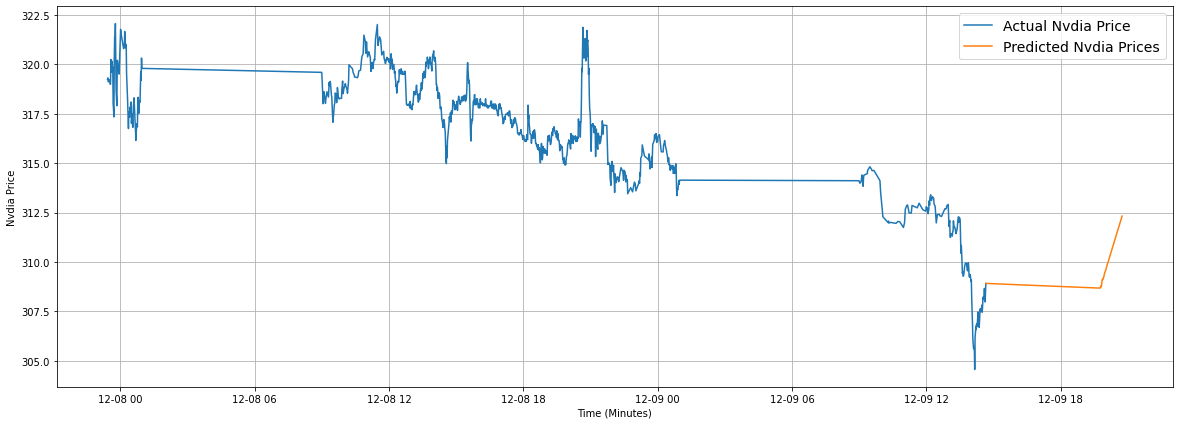

In [245]:
plt.figure(figsize=(20, 7))
plot_data(dates[-1000:], all_nvda_prices['Closing_Price'].iloc[-1000:], format='-', label='Actual Nvdia Price')
plot_data(next_timesteps, future_predictions, format='-', label='Predicted Nvdia Prices')

# The above graph does seem to be accurate. Since we are using the last 7 minutes in the dataset to predict the next 60 minutes.

In [238]:
# We can see when the last 7 datapoints were
all_nvda_prices.tail(7)

,Closing_Price
timestamp,
2021-12-09 19:39:00,308.1650
2021-12-09 19:40:00,308.3099
2021-12-09 19:41:00,308.6550
2021-12-09 19:42:00,308.2000
2021-12-09 19:43:00,307.9698
2021-12-09 19:44:00,308.5399
2021-12-09 19:45:00,308.9100


# As we can see the last 7 data points correspond to the end of the day. At the end of a day we get a horizontal like line where the price does not move. Which our model correctly predicted as seen above! 